# Supervised Model

### Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf

import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import class_weight

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_path = "../OCT2017 /train/"
test_path = "../OCT2017 /test/"

In [3]:
#BATCH_SIZE = 64
#IMG_SIZE = (224, 224)#BATCH_SIZE = 64
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

train_generator = ImageDataGenerator(validation_split=0.012)
test_generator = ImageDataGenerator() 

In [4]:
traingen = train_generator.flow_from_directory(train_path,
                                               target_size=IMG_SIZE,
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_path,
                                               target_size=IMG_SIZE,
                                               class_mode='categorical',
                                               subset = 'validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_path,
                                             target_size=IMG_SIZE,
                                             class_mode='categorical',
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 82484 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


Create base model with ResnetV2 by transfer learning

In [5]:
def create_basemodel(base_model='resnet', 
                     input_shape=(224,224,3),
                     output_units=4):
    preprocess = tf.keras.applications.resnet_v2.preprocess_input
    base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')
    base_model.trainable = False
    
    inputs = tf.keras.layers.Input(input_shape)
    pool    = tf.keras.layers.GlobalAveragePooling2D()
    flatten = tf.keras.layers.Flatten()
    
    softmax   = tf.keras.layers.Dense(output_units, activation='softmax')
    
    x = inputs
    x = preprocess(x)
    x = base_model(x)
    x = pool(x)
    x = flatten(x)
    out = softmax(x)
    
    return tf.keras.Model(inputs=inputs, outputs=out)

In [6]:
resnet_base = create_basemodel('resnet')

metrics = ['accuracy']
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', )]
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
resnet_base.compile(optimizer=optimizer, 
                    loss='categorical_crossentropy', 
                    metrics=metrics)

2022-07-13 23:11:04.491575: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-13 23:11:04.491639: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fourthbrain-oct): /proc/driver/nvidia/version does not exist
2022-07-13 23:11:04.494280: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
resnet_base.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [8]:
history = resnet_base.fit(traingen,
                          validation_data=validgen,
                          callbacks=callbacks,
                          epochs=10)

Epoch 1/10
5156/5156 [==============================] - 2779s 538ms/step - loss: 0.4369 - accuracy: 0.8438 - val_loss: 0.4335 - val_accuracy: 0.8310
Epoch 2/10
5156/5156 [==============================] - 2782s 539ms/step - loss: 0.3621 - accuracy: 0.8698 - val_loss: 0.3633 - val_accuracy: 0.8670
Epoch 3/10
5156/5156 [==============================] - 2753s 534ms/step - loss: 0.3434 - accuracy: 0.8779 - val_loss: 0.4190 - val_accuracy: 0.8550
Epoch 4/10
5156/5156 [==============================] - 2738s 531ms/step - loss: 0.3355 - accuracy: 0.8808 - val_loss: 0.3861 - val_accuracy: 0.8600
Epoch 5/10
5156/5156 [==============================] - 2696s 523ms/step - loss: 0.3286 - accuracy: 0.8820 - val_loss: 0.4029 - val_accuracy: 0.8680


In [9]:
resnet_base.evaluate(testgen)

968/968 [==============================] - 50s 52ms/step - loss: 0.3306 - accuracy: 0.8492


[0.330596387386322, 0.8491735458374023]

85% before fine tuning. Model fitting stopped after 5th epochs due to not improving 3 epochs in a row. 

In [10]:
resnet_base.save("../Models/resnet50v2_initial.h5")

### Fine Tuning

In [11]:
resnet_base.layers

Train the entire resnetV2 model except for last block.

In [12]:
# Extract the base model
base_model = resnet_base.layers[3]

# unfreeze it
base_model.trainable = True

# select only the last resnet block for retraining
# keeping the batchnorm layer unchanged
for layer in base_model.layers:
  name = layer.name
  if name.startswith('conv5_block3') and not isinstance(layer, tf.keras.layers.BatchNormalization):
    layer.trainable = True
  else:
    layer.trainable = False

optimizer = tf.keras.optimizers.Adam(lr=1e-3)
resnet_base.compile(optimizer=optimizer, 
                    loss='categorical_crossentropy', 
                    metrics=metrics)

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
resnet_base.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [14]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', )]
history = resnet_base.fit(traingen,
                          validation_data=validgen,
                          callbacks=callbacks,
                          epochs=10)

Epoch 1/10
5156/5156 [==============================] - 3102s 601ms/step - loss: 0.3514 - accuracy: 0.8845 - val_loss: 0.3053 - val_accuracy: 0.8930
Epoch 2/10
5156/5156 [==============================] - 3066s 595ms/step - loss: 0.2488 - accuracy: 0.9148 - val_loss: 0.3660 - val_accuracy: 0.8920
Epoch 3/10
5156/5156 [==============================] - 3098s 601ms/step - loss: 0.2206 - accuracy: 0.9249 - val_loss: 0.3223 - val_accuracy: 0.8950
Epoch 4/10
5156/5156 [==============================] - 3143s 610ms/step - loss: 0.1957 - accuracy: 0.9338 - val_loss: 0.3794 - val_accuracy: 0.8790


In [15]:
resnet_base.evaluate(testgen)

968/968 [==============================] - 51s 53ms/step - loss: 0.0739 - accuracy: 0.9814


[0.07390180230140686, 0.9814049601554871]

**98%** after fine tuning!

In [16]:
resnet_base.save("../Models/resnet50v2_supervised_finetuned.h5")

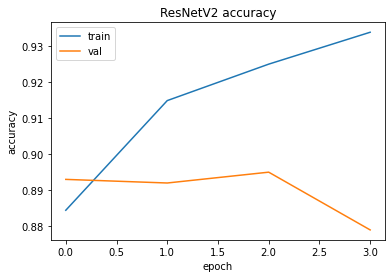

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNetV2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

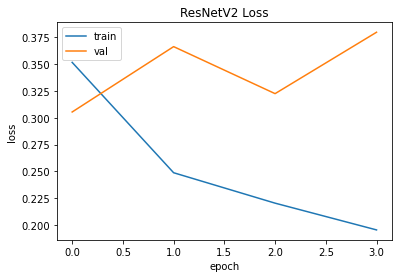

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNetV2 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()